### Data Analysis on Salary and Stats for NBA Players
We run statistical analyses to see how salary is correlated with both traditional and advanced stats like Points, Rebounds, PER, OBPM, etc. We then compute the players that most overperform their salaries in these statistical categories and the players that most underperform their salaries in these statistical categories. This enables us to identify the most overpaid and underpaid players in the NBA.

In [69]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
sns.set_style("darkgrid")

In [71]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [74]:
# import data from all the csv files
salary_df = pd.read_csv("drive/MyDrive/MS&E 125 Project/2021-22 NBA Player Salaries - Sheet1.csv")
stats_per_100_df = pd.read_csv("drive/MyDrive/MS&E 125 Project/Player Stats Per 100 Possessions.csv")

### Data Munging Section

In [75]:
# Split 'POSITION' from 'NAME' column in salary_df, shift accordingly
salary_df[['NAME', 'POSITION']] = salary_df['NAME'].str.split(', ', expand=True)
salary_df = salary_df.reindex(columns=['RK', 'NAME', 'POSITION', 'TEAM', 'SALARY'])
salary_df = salary_df.rename(columns={'NAME': 'Player'})

# Display salary dataframe
salary_df

,RK,Player,POSITION,TEAM,SALARY
0,1,Stephen Curry,PG,Golden State Warriors,"$45,780,966"
1,2,James Harden,SG,Philadelphia 76ers,"$44,310,840"
2,3,John Wall,PG,Houston Rockets,"$44,310,840"
3,4,Russell Westbrook,PG,Los Angeles Lakers,"$44,211,146"
4,5,Kevin Durant,PF,Brooklyn Nets,"$42,018,900"
...,...,...,...,...,...
496,497,Juwan Morgan,F,Toronto Raptors,"$19,816"
497,498,Moses Brown,C,Cleveland Cavaliers,"$19,186"
498,499,Xavier Sneed,F,Utah Jazz,"$8,558"
499,500,Kessler Edwards,SF,Brooklyn Nets,"$5,318"


In [76]:
# join dataframe

# Merge the datasets on the "NAME" column in salaries and the "Player" column in the stats dfs
stats_per_100_salary_df = pd.merge(salary_df, stats_per_100_df, on='Player', how='inner')

# drop duplicates (players that played on multiple teams have multiple dataframe entries)
stats_per_100_salary_df = stats_per_100_salary_df.drop_duplicates(subset='Player', keep='first')

# convert the salaries to numerical values
stats_per_100_salary_df['SALARY'] = stats_per_100_salary_df['SALARY'].replace('[\$,]', '', regex=True).astype(float)

display(stats_per_100_salary_df)

,RK,Player,POSITION,TEAM,SALARY,Rk,Pos,Age,Tm,G,...,AST,STL,BLK,TOV,PF,PTS,Unnamed: 29,ORtg,DRtg,Player-additional
0,1,Stephen Curry,PG,Golden State Warriors,45780966.0,126,PG,33,GSW,64,...,8.9,1.9,0.5,4.5,2.9,35.9,NaN,115.0,108,curryst01
1,2,James Harden,SG,Philadelphia 76ers,44310840.0,218,PG,32,TOT,65,...,13.5,1.7,0.7,5.7,3.1,29.0,NaN,115.0,111,hardeja01
4,4,Russell Westbrook,PG,Los Angeles Lakers,44211146.0,576,PG,33,LAL,78,...,9.8,1.3,0.4,5.3,4.2,25.8,NaN,102.0,114,westbru01
5,5,Kevin Durant,PF,Brooklyn Nets,42018900.0,154,PF,33,BRK,55,...,8.3,1.1,1.2,4.5,2.7,38.9,NaN,121.0,112,duranke01
6,6,LeBron James,SF,Los Angeles Lakers,41180544.0,274,C,37,LAL,56,...,8.0,1.7,1.4,4.5,2.8,39.0,NaN,117.0,111,jamesle01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
576,497,Juwan Morgan,F,Toronto Raptors,19816.0,391,PF,24,TOT,2,...,1.6,0.0,0.0,0.0,4.8,8.1,NaN,184.0,118,morgaju01
579,498,Moses Brown,C,Cleveland Cavaliers,19186.0,77,C,22,TOT,40,...,0.1,1.0,2.3,2.9,7.7,24.8,NaN,115.0,105,brownmo01
582,499,Xavier Sneed,F,Utah Jazz,8558.0,513,SF,24,TOT,9,...,1.3,0.0,0.0,0.0,2.5,6.3,NaN,75.0,117,sneedxa01
585,500,Kessler Edwards,SF,Brooklyn Nets,5318.0,158,SF,21,BRK,48,...,1.5,1.4,1.2,2.1,4.2,13.9,NaN,100.0,113,edwarke02


### Correlations of traditional stats with salary

In [77]:
# compute correlations to see what per 100 stats are most correlated with salary
per_100_corrs = stats_per_100_salary_df.corr()['SALARY']
sorted_corrs = per_100_corrs.sort_values(ascending=False)
sorted_corrs.drop(['SALARY'], inplace=True)
print(sorted_corrs.to_markdown())

|             |        SALARY |
|:------------|--------------:|
| PTS         |   0.565372    |
| GS          |   0.539343    |
| FGA         |   0.505971    |
| FG          |   0.505679    |
| FT          |   0.50209     |
| MP          |   0.499951    |
| FTA         |   0.428308    |
| AST         |   0.41383     |
| 2PA         |   0.407639    |
| TOV         |   0.358663    |
| 2P          |   0.35855     |
| Age         |   0.319315    |
| G           |   0.230452    |
| FT%         |   0.213822    |
| 3P          |   0.198889    |
| 3PA         |   0.171081    |
| DRB         |   0.13166     |
| ORtg        |   0.105233    |
| FG%         |   0.0550958   |
| 3P%         |   0.0288878   |
| STL         |   0.0238304   |
| TRB         |   0.0230821   |
| 2P%         |   0.000411854 |
| BLK         |  -0.0415268   |
| Rk          |  -0.0738231   |
| DRtg        |  -0.079946    |
| ORB         |  -0.150415    |
| PF          |  -0.25755     |
| RK          |  -0.813625    |
| Unname

<ipython-input-77-ae7ebd17cb9b>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  per_100_corrs = stats_per_100_salary_df.corr()['SALARY']


### Identifying the most overpaid and underpaid players using traditional stats

We fit linear regression models using points (PTS), assists (AST), games started (GS), field goals, (FG), field goals attempted, (FGA), and personal fouls (PF). These were some of the stats with the highest correlations with salary, and they are also relatively common, well-known traditional stat categories. Using these linear regression models, we find the 10 most overpaid and underpaid players.

In [79]:
# Fit a linear regression model
#model = LinearRegression().fit(stats_per_100_salary_df[['PTS']], stats_per_100_salary_df['SALARY'])
model=smf.ols(formula='SALARY ~ PTS', data=stats_per_100_salary_df).fit()

# Calculate the predicted values
y_pred = model.predict(stats_per_100_salary_df[['PTS']])

# Calculate the residuals
residuals = stats_per_100_salary_df['SALARY'] - y_pred

# Find the indices of the data points that are most above and below the regression line
smallest_indices = np.array(np.argsort(residuals)[:10])
greatest_indices = np.array(np.argsort(residuals)[-10:])

# print most overpaid players
for i in range(10):
  print("{}th most overpaid players in PTS per 100 possessions: {}".format(i + 1, stats_per_100_salary_df['Player'].iloc[greatest_indices[9 - i]]))

print("\n")

# print most underpaid players
for i in range(10):
  print("{}th most underpaid players in PTS per 100 possessions: {}".format(i + 1, stats_per_100_salary_df['Player'].iloc[smallest_indices[i]]))

[-21242101.499742217, -15272038.28584309, -14916158.056962393, -14099921.865951335, -13397296.190545425]
[25007418.485276215, 25013279.50816428, 25764641.828597255, 29859891.756187655, 32341241.664635375]
1th most overpaid players in PTS per 100 possessions: Russell Westbrook
2th most overpaid players in PTS per 100 possessions: James Harden
3th most overpaid players in PTS per 100 possessions: Stephen Curry
4th most overpaid players in PTS per 100 possessions: Tobias Harris
5th most overpaid players in PTS per 100 possessions: Rudy Gobert
6th most overpaid players in PTS per 100 possessions: Draymond Green
7th most overpaid players in PTS per 100 possessions: Damian Lillard
8th most overpaid players in PTS per 100 possessions: Al Horford
9th most overpaid players in PTS per 100 possessions: Chris Paul
10th most overpaid players in PTS per 100 possessions: Paul George


1th most underpaid players in PTS per 100 possessions: Sekou Doumbouya
2th most underpaid players in PTS per 100 poss

<ipython-input-93-0de86f7d6877>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(top_10_positive_residuals['NAME'].tolist() + top_10_negative_residuals['NAME'].tolist())


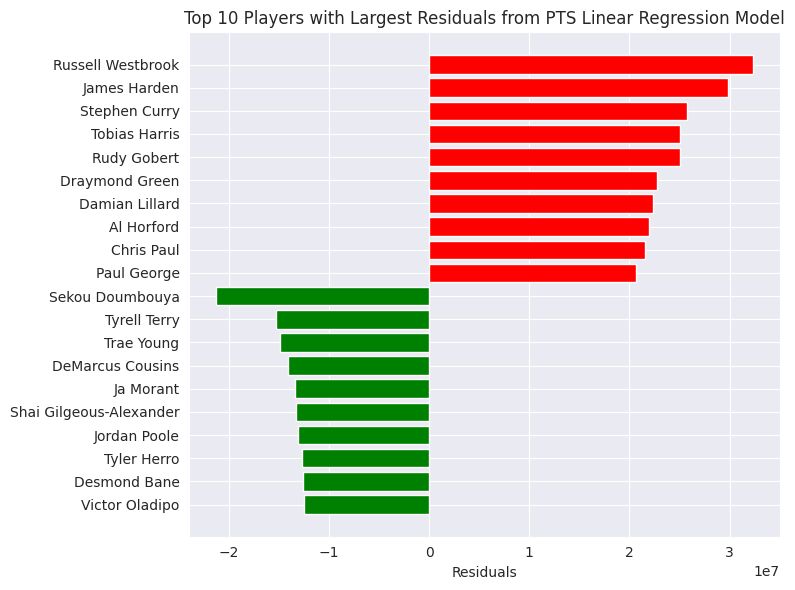

In [93]:
import matplotlib.pyplot as plt

# get the 10 highest and 10 lowest residuals and put them together with the 
# player names in a dataframe
smallest_residuals = sorted(list(residuals))[:10]
greatest_residuals = sorted(list(residuals))[-10:]
smallest_players = [stats_per_100_salary_df['Player'].iloc[smallest_indices[i]] for i in range(10)]
greatest_players = [stats_per_100_salary_df['Player'].iloc[greatest_indices[-1 - i]] for i in range(10)]
greatest_players.reverse()

positive_data = {'NAME': greatest_players, 'Residuals': greatest_residuals}
top_10_positive_residuals = pd.DataFrame(positive_data, columns=['NAME', 'Residuals'])

negative_data = {'NAME': smallest_players, 'Residuals': smallest_residuals}
top_10_negative_residuals = pd.DataFrame(negative_data, columns=['NAME', 'Residuals'])

# Sort the top 10 positive and negative residuals in descending order
top_10_positive_residuals = top_10_positive_residuals.sort_values(by='Residuals', ascending=False)
top_10_negative_residuals = top_10_negative_residuals.sort_values(by='Residuals', ascending=True)

# Create the plot
fig, ax = plt.subplots(sharex=True, figsize=(8, 6))

# Plot the positive residuals in red
ax.barh(top_10_positive_residuals['NAME'], top_10_positive_residuals['Residuals'], color='red')
# Plot the negative residuals in green
ax.barh(top_10_negative_residuals['NAME'], top_10_negative_residuals['Residuals'], color='green')

# Set the y-axis labels
ax.set_yticklabels(top_10_positive_residuals['NAME'].tolist() + top_10_negative_residuals['NAME'].tolist())
ax.invert_yaxis()

# Set the x-axis label and title
ax.set_xlabel('Residuals')
ax.set_title('Top 10 Players with Largest Residuals from PTS Linear Regression Model')

# Adjust the spacing
plt.tight_layout()

# Save the plot as a JPG image
plt.savefig('residuals_plot.jpg')

# Show the plot
plt.show()

In [ ]:
# Fit a linear regression model
model = LinearRegression().fit(stats_per_100_salary_df[['AST']], stats_per_100_salary_df['SALARY'])

# Calculate the predicted values
y_pred = model.predict(stats_per_100_salary_df[['AST']])

# Calculate the residuals
residuals = stats_per_100_salary_df['SALARY'] - y_pred

# Find the indices of the data points that are most above and below the regression line
smallest_indices = np.array(np.argsort(residuals)[:10])
greatest_indices = np.array(np.argsort(residuals)[-10:])

# print most overpaid players
for i in range(10):
  print("{}th most overpaid players in AST per 100 possessions: {}".format(i + 1, stats_per_100_salary_df['Player'].iloc[greatest_indices[9 - i]]))

print("\n")

# print most underpaid players
for i in range(10):
  print("{}th most underpaid players in AST per 100 possessions: {}".format(i + 1, stats_per_100_salary_df['Player'].iloc[smallest_indices[i]]))

1th most overpaid players in AST per 100 possessions: Stephen Curry
2th most overpaid players in AST per 100 possessions: Rudy Gobert
3th most overpaid players in AST per 100 possessions: Klay Thompson
4th most overpaid players in AST per 100 possessions: Russell Westbrook
5th most overpaid players in AST per 100 possessions: Kevin Durant
6th most overpaid players in AST per 100 possessions: LeBron James
7th most overpaid players in AST per 100 possessions: Anthony Davis
8th most overpaid players in AST per 100 possessions: Tobias Harris
9th most overpaid players in AST per 100 possessions: Paul George
10th most overpaid players in AST per 100 possessions: Giannis Antetokounmpo


1th most underpaid players in AST per 100 possessions: Rajon Rondo
2th most underpaid players in AST per 100 possessions: Lance Stephenson
3th most underpaid players in AST per 100 possessions: Jose Alvarado
4th most underpaid players in AST per 100 possessions: Tre Jones
5th most underpaid players in AST per 

In [ ]:
# Fit a linear regression model
model = LinearRegression().fit(stats_per_100_salary_df[['GS']], stats_per_100_salary_df['SALARY'])

# Calculate the predicted values
y_pred = model.predict(stats_per_100_salary_df[['GS']])

# Calculate the residuals
residuals = stats_per_100_salary_df['SALARY'] - y_pred

# Find the indices of the data points that are most above and below the regression line
smallest_indices = np.array(np.argsort(residuals)[:10])
greatest_indices = np.array(np.argsort(residuals)[-10:])

# print most overpaid players
for i in range(10):
  print("{}th most overpaid players in GS per 100 possessions: {}".format(i + 1, stats_per_100_salary_df['Player'].iloc[greatest_indices[9 - i]]))

print("\n")

# print most underpaid players
for i in range(10):
  print("{}th most underpaid players in GS per 100 possessions: {}".format(i + 1, stats_per_100_salary_df['Player'].iloc[smallest_indices[i]]))

1th most overpaid players in GS per 100 possessions: Damian Lillard
2th most overpaid players in GS per 100 possessions: Stephen Curry
3th most overpaid players in GS per 100 possessions: Paul George
4th most overpaid players in GS per 100 possessions: James Harden
5th most overpaid players in GS per 100 possessions: Klay Thompson
6th most overpaid players in GS per 100 possessions: Kevin Durant
7th most overpaid players in GS per 100 possessions: LeBron James
8th most overpaid players in GS per 100 possessions: Kevin Love
9th most overpaid players in GS per 100 possessions: Kyrie Irving
10th most overpaid players in GS per 100 possessions: Russell Westbrook


1th most underpaid players in GS per 100 possessions: Jae'Sean Tate
2th most underpaid players in GS per 100 possessions: Saddiq Bey
3th most underpaid players in GS per 100 possessions: Desmond Bane
4th most underpaid players in GS per 100 possessions: Keldon Johnson
5th most underpaid players in GS per 100 possessions: Tyrese M

In [ ]:
# Fit a linear regression model
model = LinearRegression().fit(stats_per_100_salary_df[['FG']], stats_per_100_salary_df['SALARY'])

# Calculate the predicted values
y_pred = model.predict(stats_per_100_salary_df[['FG']])

# Calculate the residuals
residuals = stats_per_100_salary_df['SALARY'] - y_pred

# Find the indices of the data points that are most above and below the regression line
smallest_indices = np.array(np.argsort(residuals)[:10])
greatest_indices = np.array(np.argsort(residuals)[-10:])

# print most overpaid players
for i in range(10):
  print("{}th most overpaid players in FG per 100 possessions: {}".format(i + 1, stats_per_100_salary_df['Player'].iloc[greatest_indices[9 - i]]))

print("\n")

# print most underpaid players
for i in range(10):
  print("{}th most underpaid players in FG per 100 possessions: {}".format(i + 1, stats_per_100_salary_df['Player'].iloc[smallest_indices[i]]))

1th most overpaid players in FG per 100 possessions: James Harden
2th most overpaid players in FG per 100 possessions: Russell Westbrook
3th most overpaid players in FG per 100 possessions: Stephen Curry
4th most overpaid players in FG per 100 possessions: Damian Lillard
5th most overpaid players in FG per 100 possessions: Rudy Gobert
6th most overpaid players in FG per 100 possessions: Tobias Harris
7th most overpaid players in FG per 100 possessions: Jimmy Butler
8th most overpaid players in FG per 100 possessions: Khris Middleton
9th most overpaid players in FG per 100 possessions: Paul George
10th most overpaid players in FG per 100 possessions: Kevin Durant


1th most underpaid players in FG per 100 possessions: Tyrell Terry
2th most underpaid players in FG per 100 possessions: Sekou Doumbouya
3th most underpaid players in FG per 100 possessions: LaMarcus Aldridge
4th most underpaid players in FG per 100 possessions: Bruno Fernando
5th most underpaid players in FG per 100 possessi

In [ ]:
# Fit a linear regression model
model = LinearRegression().fit(stats_per_100_salary_df[['FGA']], stats_per_100_salary_df['SALARY'])

# Calculate the predicted values
y_pred = model.predict(stats_per_100_salary_df[['FGA']])

# Calculate the residuals
residuals = stats_per_100_salary_df['SALARY'] - y_pred

## Find the indices of the data points that are most above and below the regression line
smallest_indices = np.array(np.argsort(residuals)[:10])
greatest_indices = np.array(np.argsort(residuals)[-10:])

# print most overpaid players
for i in range(10):
  print("{}th most overpaid players in FGA per 100 possessions: {}".format(i + 1, stats_per_100_salary_df['Player'].iloc[greatest_indices[9 - i]]))

print("\n")

# print most underpaid players
for i in range(10):
  print("{}th most underpaid players in FGA per 100 possessions: {}".format(i + 1, stats_per_100_salary_df['Player'].iloc[smallest_indices[i]]))

1th most overpaid players in FGA per 100 possessions: James Harden
2th most overpaid players in FGA per 100 possessions: Rudy Gobert
3th most overpaid players in FGA per 100 possessions: Russell Westbrook
4th most overpaid players in FGA per 100 possessions: Stephen Curry
5th most overpaid players in FGA per 100 possessions: Tobias Harris
6th most overpaid players in FGA per 100 possessions: Kevin Durant
7th most overpaid players in FGA per 100 possessions: Jimmy Butler
8th most overpaid players in FGA per 100 possessions: Draymond Green
9th most overpaid players in FGA per 100 possessions: Damian Lillard
10th most overpaid players in FGA per 100 possessions: Chris Paul


1th most underpaid players in FGA per 100 possessions: Isaiah Thomas
2th most underpaid players in FGA per 100 possessions: Tyler Herro
3th most underpaid players in FGA per 100 possessions: DeMarcus Cousins
4th most underpaid players in FGA per 100 possessions: Trey Burke
5th most underpaid players in FGA per 100 pos

In [96]:
# Fit a linear regression model
model = LinearRegression().fit(stats_per_100_salary_df[['PF']], stats_per_100_salary_df['SALARY'])

# Calculate the predicted values
y_pred = model.predict(stats_per_100_salary_df[['PF']])

# Calculate the residuals
residuals = stats_per_100_salary_df['SALARY'] - y_pred

# Find the indices of the data points that are most above and below the regression line
smallest_indices = np.array(np.argsort(residuals)[:10])
greatest_indices = np.array(np.argsort(residuals)[-10:])

# print most overpaid players
for i in range(10):
  print("{}th most overpaid players in PF per 100 possessions: {}".format(i + 1, stats_per_100_salary_df['Player'].iloc[greatest_indices[9 - i]]))

print("\n")

# print most underpaid players
for i in range(10):
  print("{}th most underpaid players in PF per 100 possessions: {}".format(i + 1, stats_per_100_salary_df['Player'].iloc[smallest_indices[i]]))

1th most overpaid players in PF per 100 possessions: Russell Westbrook
2th most overpaid players in PF per 100 possessions: Stephen Curry
3th most overpaid players in PF per 100 possessions: James Harden
4th most overpaid players in PF per 100 possessions: Giannis Antetokounmpo
5th most overpaid players in PF per 100 possessions: Kevin Durant
6th most overpaid players in PF per 100 possessions: LeBron James
7th most overpaid players in PF per 100 possessions: Paul George
8th most overpaid players in PF per 100 possessions: Klay Thompson
9th most overpaid players in PF per 100 possessions: Damian Lillard
10th most overpaid players in PF per 100 possessions: Rudy Gobert


1th most underpaid players in PF per 100 possessions: Sam Dekker
2th most underpaid players in PF per 100 possessions: Jaden Springer
3th most underpaid players in PF per 100 possessions: Nik Stauskas
4th most underpaid players in PF per 100 possessions: D.J. Augustin
5th most underpaid players in PF per 100 possessions

<ipython-input-97-a91212947c0a>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(top_10_positive_residuals['NAME'].tolist() + top_10_negative_residuals['NAME'].tolist())


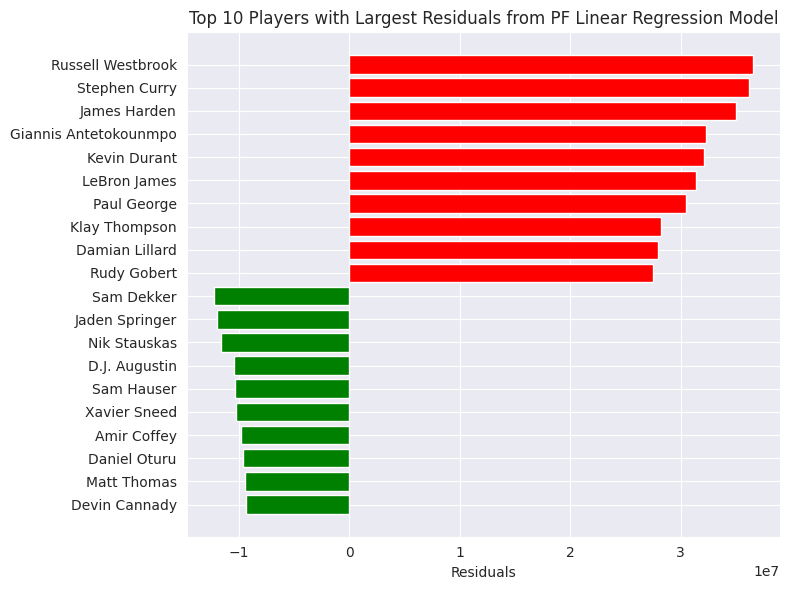

In [97]:
import matplotlib.pyplot as plt

# get the 10 highest and 10 lowest residuals and put them together with the 
# player names in a dataframe
smallest_residuals = sorted(list(residuals))[:10]
greatest_residuals = sorted(list(residuals))[-10:]
smallest_players = [stats_per_100_salary_df['Player'].iloc[smallest_indices[i]] for i in range(10)]
greatest_players = [stats_per_100_salary_df['Player'].iloc[greatest_indices[-1 - i]] for i in range(10)]
greatest_players.reverse()

positive_data = {'NAME': greatest_players, 'Residuals': greatest_residuals}
top_10_positive_residuals = pd.DataFrame(positive_data, columns=['NAME', 'Residuals'])

negative_data = {'NAME': smallest_players, 'Residuals': smallest_residuals}
top_10_negative_residuals = pd.DataFrame(negative_data, columns=['NAME', 'Residuals'])

# Sort the top 10 positive and negative residuals in descending order
top_10_positive_residuals = top_10_positive_residuals.sort_values(by='Residuals', ascending=False)
top_10_negative_residuals = top_10_negative_residuals.sort_values(by='Residuals', ascending=True)

# Create the plot
fig, ax = plt.subplots(sharex=True, figsize=(8, 6))

# Plot the positive residuals in red
ax.barh(top_10_positive_residuals['NAME'], top_10_positive_residuals['Residuals'], color='red')
# Plot the negative residuals in green
ax.barh(top_10_negative_residuals['NAME'], top_10_negative_residuals['Residuals'], color='green')

# Set the y-axis labels
ax.set_yticklabels(top_10_positive_residuals['NAME'].tolist() + top_10_negative_residuals['NAME'].tolist())
ax.invert_yaxis()

# Set the x-axis label and title
ax.set_xlabel('Residuals')
ax.set_title('Top 10 Players with Largest Residuals from PF Linear Regression Model')

# Adjust the spacing
plt.tight_layout()

# Save the plot as a JPG image
plt.savefig('residuals_plot.jpg')

# Show the plot
plt.show()

### Fit a multiple regression using traditional stats, then identify the most overpaid and underpaid players

Fit a multiple regression model using all of the traditional stat categories except the ones that have a correlation with salary of less than 0.1. Using this multiple regression model, identify the stats that have the lowest p-values, and fit another multiple regression model using just those stats.

In [ ]:
model = smf.ols(formula='SALARY ~ PTS + AST + GS + MP + FG + FGA + Q("3P") + Q("3PA") + Q("2P") + Q("2PA") + FT + FTA + Q("FT%") + ORB + DRB + AST + TOV + PF + PTS', data=stats_per_100_salary_df).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 SALARY   R-squared:                       0.519
Model:                            OLS   Adj. R-squared:                  0.499
Method:                 Least Squares   F-statistic:                     26.43
Date:                Thu, 08 Jun 2023   Prob (F-statistic):           9.64e-56
Time:                        22:32:39   Log-Likelihood:                -7446.4
No. Observations:                 435   AIC:                         1.493e+04
Df Residuals:                     417   BIC:                         1.500e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.299e+06   4.47e+06     -0.291      0.771   -1.01e+07    7.48e+06
PTS          6.37e+06   4.44e+06      1.434      0.152   -2.36e+06    1.51e+07
AST         7.745e+05   1.82e+05      4.253      0.000    4.17e+05    1.13e+06
GS          1.309e+05   2.37e+04      5.524      0.000    8.43e+04    1.78e+05
MP         -1649.0833    934.372     -1.765      0.078   -3485.750     187.583
FG         -1.644e+07   1.01e+07     -1.631      0.104   -3.63e+07    3.38e+06
FGA        -2.565e+06   6.79e+06     -0.378      0.706   -1.59e+07    1.08e+07
Q("3P")    -8.674e+05   9.14e+06     -0.095      0.924   -1.88e+07    1.71e+07
Q("3PA")    2.423e+06   6.76e+06      0.358      0.720   -1.09e+07    1.57e+07
Q("2P")     4.269e+06    7.1e+06      0.601      0.548    -9.7e+06    1.82e+07
Q("2PA")    2.604e+06   6.79e+06      0.384      0.701   -1.07e+07    1.59e+07
FT         -3.183e+06   4.55e+06     -0.699      0.485   -1.21e+07    5.76e+06
FTA        -1.458e+06   8.99e+05     -1.623      0.105   -3.22e+06    3.08e+05
Q("FT%")   -7.435e+06   4.86e+06     -1.531      0.126    -1.7e+07    2.11e+06
ORB        -2.785e+05   3.34e+05     -0.833      0.405   -9.35e+05    3.78e+05
DRB         6.732e+05   1.73e+05      3.900      0.000    3.34e+05    1.01e+06
TOV        -4.522e+05   4.56e+05     -0.991      0.322   -1.35e+06    4.45e+05
PF         -8.165e+05   2.83e+05     -2.884      0.004   -1.37e+06    -2.6e+05
==============================================================================
Omnibus:                       37.239   Durbin-Watson:                   1.084
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               64.327
Skew:                           0.548   Prob(JB):                     1.08e-14
Kurtosis:                       4.533   Cond. No.                     5.42e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.42e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [99]:
model=smf.ols(formula='SALARY ~ AST + GS + DRB + PF', data=stats_per_100_salary_df).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 SALARY   R-squared:                       0.397
Model:                            OLS   Adj. R-squared:                  0.391
Method:                 Least Squares   F-statistic:                     72.65
Date:                Thu, 08 Jun 2023   Prob (F-statistic):           2.81e-47
Time:                        23:46:32   Log-Likelihood:                -7699.1
No. Observations:                 447   AIC:                         1.541e+04
Df Residuals:                     442   BIC:                         1.543e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.193e+06   1.47e+06     -0.811      0.418   -4.08e+06     1.7e+06
AST         9.782e+05   1.38e+05      7.108      0.000    7.08e+05    1.25e+06
GS          1.427e+05   1.42e+04     10.057      0.000    1.15e+05    1.71e+05
DRB         6.467e+05   1.39e+05      4.667      0.000    3.74e+05    9.19e+05
PF         -8.285e+05   2.38e+05     -3.484      0.001    -1.3e+06   -3.61e+05
==============================================================================
Omnibus:                       93.604   Durbin-Watson:                   0.731
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              184.706
Skew:                           1.142   Prob(JB):                     7.79e-41
Kurtosis:                       5.169   Cond. No.                         160.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now identify the most underpaid and overpaid players according to the multiple regression model.

In [100]:
# Calculate the predicted values
y_pred = model.predict(stats_per_100_salary_df)

# Calculate the residuals
residuals = stats_per_100_salary_df['SALARY'] - y_pred

# Find the indices of the data points that are most above and below the regression line
smallest_indices = np.array(np.argsort(residuals)[:10])
greatest_indices = np.array(np.argsort(residuals)[-10:])

# print most overpaid players
for i in range(10):
  print("{}th most overpaid players in per 100 possessions: {}".format(i + 1, stats_per_100_salary_df['Player'].iloc[greatest_indices[9 - i]]))

print("\n")

# print most underpaid players
for i in range(10):
  print("{}th most underpaid players in per 100 possessions: {}".format(i + 1, stats_per_100_salary_df['Player'].iloc[smallest_indices[i]]))

1th most overpaid players in per 100 possessions: Klay Thompson
2th most overpaid players in per 100 possessions: Stephen Curry
3th most overpaid players in per 100 possessions: Paul George
4th most overpaid players in per 100 possessions: Damian Lillard
5th most overpaid players in per 100 possessions: Kyrie Irving
6th most overpaid players in per 100 possessions: Kevin Durant
7th most overpaid players in per 100 possessions: Anthony Davis
8th most overpaid players in per 100 possessions: LeBron James
9th most overpaid players in per 100 possessions: Russell Westbrook
10th most overpaid players in per 100 possessions: Kevin Love


1th most underpaid players in per 100 possessions: Tyrese Haliburton
2th most underpaid players in per 100 possessions: Trae Young
3th most underpaid players in per 100 possessions: Kevin Porter Jr.
4th most underpaid players in per 100 possessions: Cole Anthony
5th most underpaid players in per 100 possessions: Josh Giddey
6th most underpaid players in per 

<ipython-input-102-e6f7b304ba1b>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(top_10_positive_residuals['NAME'].tolist() + top_10_negative_residuals['NAME'].tolist())


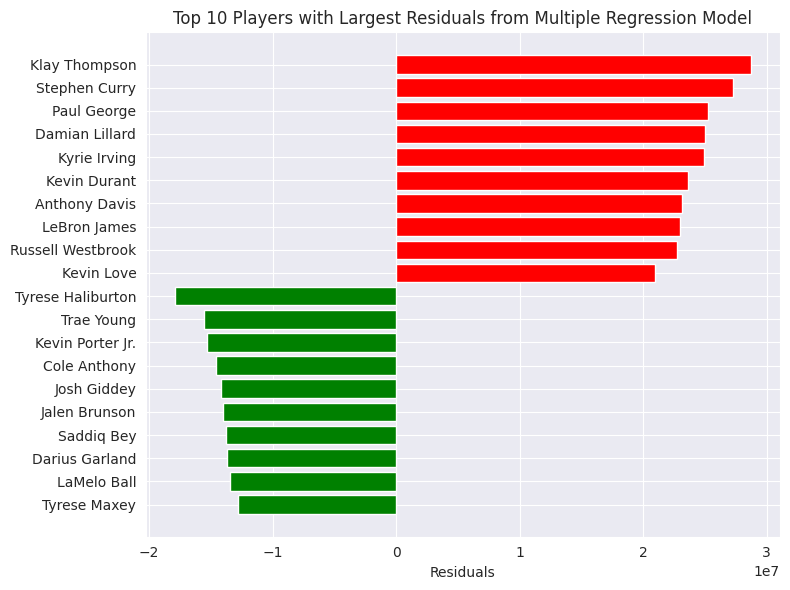

In [102]:
import matplotlib.pyplot as plt

# get the 10 highest and 10 lowest residuals and put them together with the 
# player names in a dataframe
smallest_residuals = sorted(list(residuals))[:10]
greatest_residuals = sorted(list(residuals))[-10:]
smallest_players = [stats_per_100_salary_df['Player'].iloc[smallest_indices[i]] for i in range(10)]
greatest_players = [stats_per_100_salary_df['Player'].iloc[greatest_indices[-1 - i]] for i in range(10)]
greatest_players.reverse()

positive_data = {'NAME': greatest_players, 'Residuals': greatest_residuals}
top_10_positive_residuals = pd.DataFrame(positive_data, columns=['NAME', 'Residuals'])

negative_data = {'NAME': smallest_players, 'Residuals': smallest_residuals}
top_10_negative_residuals = pd.DataFrame(negative_data, columns=['NAME', 'Residuals'])

# Sort the top 10 positive and negative residuals in descending order
top_10_positive_residuals = top_10_positive_residuals.sort_values(by='Residuals', ascending=False)
top_10_negative_residuals = top_10_negative_residuals.sort_values(by='Residuals', ascending=True)

# Create the plot
fig, ax = plt.subplots(sharex=True, figsize=(8, 6))

# Plot the positive residuals in red
ax.barh(top_10_positive_residuals['NAME'], top_10_positive_residuals['Residuals'], color='red')
# Plot the negative residuals in green
ax.barh(top_10_negative_residuals['NAME'], top_10_negative_residuals['Residuals'], color='green')

# Set the y-axis labels
ax.set_yticklabels(top_10_positive_residuals['NAME'].tolist() + top_10_negative_residuals['NAME'].tolist())
ax.invert_yaxis()

# Set the x-axis label and title
ax.set_xlabel('Residuals')
ax.set_title('Top 10 Players with Largest Residuals from Multiple Regression Model')

# Adjust the spacing
plt.tight_layout()

# Save the plot as a JPG image
plt.savefig('residuals_plot.jpg')

# Show the plot
plt.show()

# 5-Fold Cross Validation using multiple linear regression model with all advanced stats and only the one with relevant p-values

In [ ]:
rows = stats_per_100_salary_df.shape[0]
folds = np.array_split(stats_per_100_salary_df.sample(rows), 5)

rmse_list = []
for i in range(5):
  val_df = folds[i]
  train_df = pd.concat(folds[:i] + folds[i+1:])

  # training models on train data
  model_all = smf.ols(formula='SALARY ~ PTS + AST + GS + MP + FG + FGA + Q("3P") + Q("3PA") + Q("2P") + Q("2PA") + FT + FTA + Q("FT%") + ORB + DRB + AST + TOV + PF + PTS', data=train_df).fit()
  model_four = smf.ols(formula='SALARY ~ AST + GS + DRB + PF', data=train_df).fit()

  rmse_all = np.sqrt(np.mean((val_df['SALARY'] - model_all.predict(val_df))**2))
  rmse_four = np.sqrt(np.mean((val_df['SALARY'] - model_four.predict(val_df))**2))
  
  rmse_list.append([rmse_all, rmse_four])

avg_rmse_df = pd.DataFrame(rmse_list, columns=['All per 100 Stats', 'Only Four'])
avg_rmse_df.mean()

All per 100 Stats    6.877437e+06
Only Four            7.473596e+06
dtype: float64